In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit, float64
from numba.types import UniTuple
from time import time

In [4]:
# Implementation of Eq. (1) in the exam set
def doublegyre(x, y, t, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x**2 + b*x
    return np.array([
            -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*y),              # x component of velocity
             np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*y) * (2*a*x + b) # y component of velocity
        ])


# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
def f(X, t):
    # Parameters of the velocity field
    A = 0.1
    e = 0.25 # epsilon
    w = 1    # omega
    return doublegyre(X[0], X[1], t, A, e, w)


# Forward Euler integrator
# X0 is a two-component vector [x, y]
def euler(X, t, dt, f):
    k1 = f(X,           t)
    return X + dt*k1


# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]
def rk4(X, t, dt, f):
    k1 = f(X,           t)
    k2 = f(X + k1*dt/2, t + dt/2)
    k3 = f(X + k2*dt/2, t + dt/2)
    k4 = f(X + k3*dt,   t + dt)
    return X + dt*(k1 + 2*k2 + 2*k3 + k4) / 6


# Function to calculate a trajectory from an
# initial position X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator
def trajectory(X0, tmax, dt, integrator, f):
    t    = 0
    # Number of timesteps
    Nx = int(tmax / dt)
    # Array to hold the entire trajectory
    PX = np.zeros((2, Nx+1))
    # Initial position
    PX[:,0] = X0
    # Loop over all timesteps
    for i in range(1, Nx+1):
        PX[:,i] = integrator(PX[:,i-1], t, dt, f)
        t += dt
    # Return entire trajectory
    return PX

# Transport a collection of particles

(0, 1)

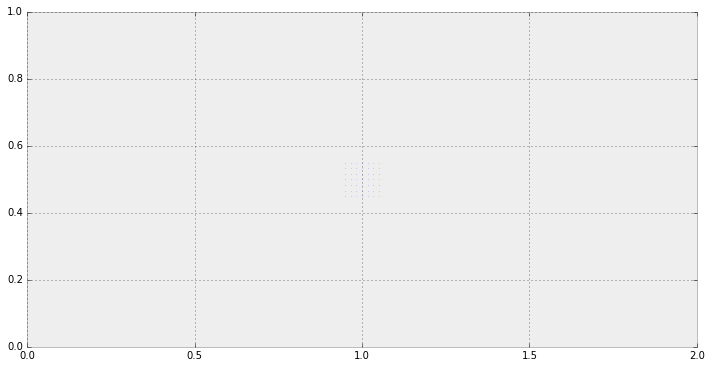

In [30]:
def grid_of_particles(N, w):
    # Create a grid of N evenly spaced particles
    # covering a square patch of width and height w
    # centered on the region 0 < x < 2, 0 < y < 1
    x  = np.linspace(1.0-w/2, 1.0+w/2, int(np.sqrt(N)))
    y  = np.linspace(0.5-w/2, 0.5+w/2, int(np.sqrt(N)))
    x, y = np.meshgrid(x, y)
    return np.array([x.flatten(), y.flatten()])

X = grid_of_particles(50, 0.1)
# Make a plot to confirm that this works as expected
fig = plt.figure(figsize  = (12,6))
plt.scatter(X[0,:], X[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

In [31]:
X

array([[ 0.95      ,  0.96666667,  0.98333333,  1.        ,  1.01666667,
         1.03333333,  1.05      ,  0.95      ,  0.96666667,  0.98333333,
         1.        ,  1.01666667,  1.03333333,  1.05      ,  0.95      ,
         0.96666667,  0.98333333,  1.        ,  1.01666667,  1.03333333,
         1.05      ,  0.95      ,  0.96666667,  0.98333333,  1.        ,
         1.01666667,  1.03333333,  1.05      ,  0.95      ,  0.96666667,
         0.98333333,  1.        ,  1.01666667,  1.03333333,  1.05      ,
         0.95      ,  0.96666667,  0.98333333,  1.        ,  1.01666667,
         1.03333333,  1.05      ,  0.95      ,  0.96666667,  0.98333333,
         1.        ,  1.01666667,  1.03333333,  1.05      ],
       [ 0.45      ,  0.45      ,  0.45      ,  0.45      ,  0.45      ,
         0.45      ,  0.45      ,  0.46666667,  0.46666667,  0.46666667,
         0.46666667,  0.46666667,  0.46666667,  0.46666667,  0.48333333,
         0.48333333,  0.48333333,  0.48333333,  0.48333333,  0.

## Optimization - Step 1: Naïve loop implementation

Transport took 4.394 seconds


(0, 1)

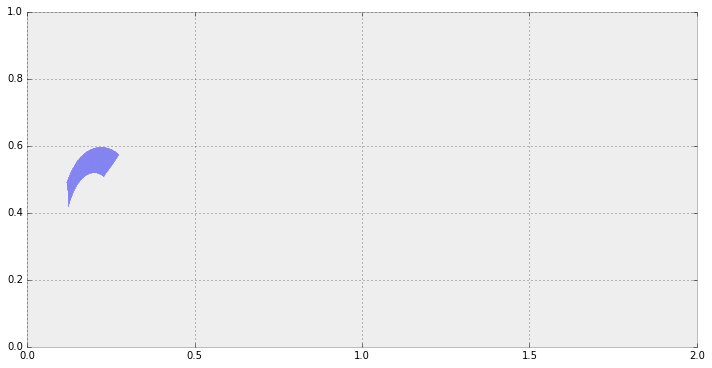

In [18]:
N  = 10000
X0 = grid_of_particles(N, w = 0.1)
# Array to hold all grid points after transport
X1 = np.zeros((2, N))

# Transport parameters
tmax = 5.0
dt   = 0.5

# Loop over grid and update all positions
# This is where parallelisation would happen, since
# each position is independent of all the others
tic = time()
for i in range(N):
    # Keep only the last position, not the entire trajectory
    X1[:,i] = trajectory(X0[:,i], tmax, dt, rk4, f)[:,-1]
toc = time()
print('Transport took %.3f seconds' % (toc - tic))

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

## Optimization - Step 2: NumPy array operations

In [21]:
# Implementation of Eq. (1) in the exam set
def doublegyre(x, y, t, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x**2 + b*x
    return np.array([
            -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*y),              # x component of velocity
             np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*y) * (2*a*x + b) # y component of velocity
        ])


# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
def f(X, t):
    # Parameters of the velocity field
    A = 0.1
    e = 0.25 # epsilon
    w = 1    # omega
    return doublegyre(X[0,:], X[1,:], t, A, e, w)


# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]
def rk4(X, t, dt, f):
    k1 = f(X,           t)
    k2 = f(X + k1*dt/2, t + dt/2)
    k3 = f(X + k2*dt/2, t + dt/2)
    k4 = f(X + k3*dt,   t + dt)
    return X + dt*(k1 + 2*k2 + 2*k3 + k4) / 6


# Function to calculate a trajectory from an
# initial position X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator
def trajectory(X0, tmax, dt, integrator, f):
    t    = 0
    # Number of timesteps
    Nt = int(tmax / dt)
    # Array to hold the entire trajectory
    PX = np.zeros((*X0.shape, Nt+1))
    # Initial position
    PX[:,:,0] = X0
    # Loop over all timesteps
    for i in range(1, Nt+1):
        PX[:,:,i] = integrator(PX[:,:,i-1], t, dt, f)
        t += dt
    # Return entire trajectory
    return PX

Transport took 0.021 seconds


(0, 1)

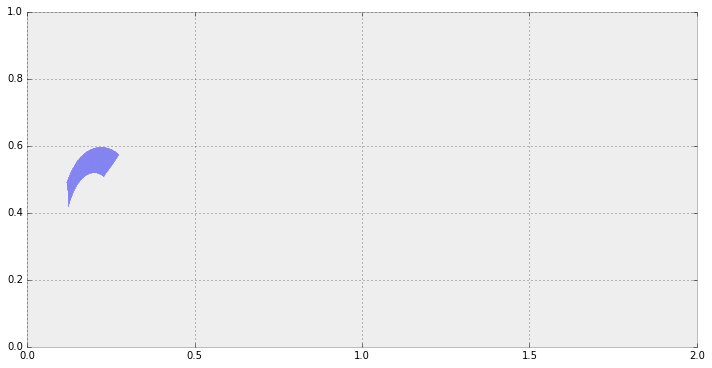

In [22]:
N  = 10000
X0 = grid_of_particles(N, w = 0.1)
# Array to hold all grid points after transport
X1 = np.zeros((2, N))

# Transport parameters
tmax = 5.0
dt   = 0.5

# Loop over grid and update all positions
# This is where parallelisation would happen, since
# each position is independent of all the others
tic = time()
# Keep only the last position, not the entire trajectory
X1 = trajectory(X0, tmax, dt, rk4, f)[:,:,-1]
toc = time()
print('Transport took %.3f seconds' % (toc - tic))

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

## Optimization - Step 3: Rewrite trajectory function to only return final location

In [124]:
# Implementation of Eq. (1) in the exam set
def doublegyre(x, y, t, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x**2 + b*x
    return np.array([
            -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*y),              # x component of velocity
             np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*y) * (2*a*x + b) # y component of velocity
        ])


# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
def f(X, t):
    # Parameters of the velocity field
    A = 0.1
    e = 0.25 # epsilon
    w = 1    # omega
    return doublegyre(X[0,:], X[1,:], t, A, e, w)


# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]
def rk4(X, t, dt, f):
    k1 = f(X,           t)
    k2 = f(X + k1*dt/2, t + dt/2)
    k3 = f(X + k2*dt/2, t + dt/2)
    k4 = f(X + k3*dt,   t + dt)
    return X + dt*(k1 + 2*k2 + 2*k3 + k4) / 6


# Function to calculate a trajectory from an
# initial position X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator
def trajectory(X, tmax, dt, integrator, f):
    t    = 0
    # Number of timesteps
    Nt = int(tmax / dt)
    # Loop over all timesteps
    for i in range(1, Nt+1):
        X = integrator(X, t, dt, f)
        t += dt
    # Return entire trajectory
    return X

Transport took 0.036 seconds


(0, 1)

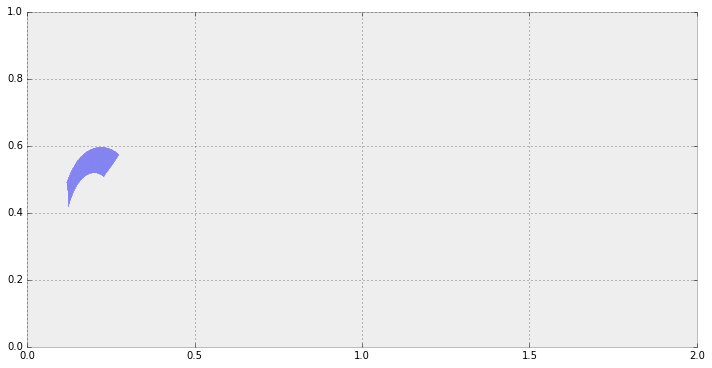

In [125]:
N  = 10000
X0 = grid_of_particles(N, w = 0.1)
# Array to hold all grid points after transport
X1 = np.zeros((2, N))

# Transport parameters
tmax = 5.0
dt   = 0.5

# Loop over grid and update all positions
# This is where parallelisation would happen, since
# each position is independent of all the others
tic = time()
# Keep only the last position, not the entire trajectory
X1 = trajectory(X0, tmax, dt, rk4, f)
toc = time()
print('Transport took %.3f seconds' % (toc - tic))

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

## Optimization - Step 4: Just-in-time compilation with Numba

In [22]:
# Implementation of Eq. (1) in the exam set
@jit(UniTuple(float64[:], 2)(float64[:], float64[:], float64, float64, float64, float64), nopython = True)
def doublegyre(x, y, t, A, e, w):
    a = e * np.sin(w*t)
    b = 1 - 2*e*np.sin(w*t)
    f = a*x**2 + b*x
    v = np.zeros((2, x.size))
    return -np.pi*A*np.sin(np.pi*f) * np.cos(np.pi*y), np.pi*A*np.cos(np.pi*f) * np.sin(np.pi*y) * (2*a*x + b)

# Wrapper function to pass to integrator
# X0 is a two-component vector [x, y]
@jit(nopython = True)
def f(X, t):
    # Parameters of the velocity field
    A = np.float64(0.1)
    e = np.float64(0.25) # epsilon
    w = np.float64(1.0)  # omega
    v = np.zeros(X.shape)
    v[0,:], v[1,:] = doublegyre(X[0,:], X[1,:], t, A, e, w)
    return v

# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]
@jit(nopython = True)
def rk4(X, t, dt):
    k1 = f(X,           t)
    k2 = f(X + k1*dt/2, t + dt/2)
    k3 = f(X + k2*dt/2, t + dt/2)
    k4 = f(X + k3*dt,   t + dt)
    return X + dt*(k1 + 2*k2 + 2*k3 + k4) / 6


# Function to calculate a trajectory from an
# initial position X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator
@jit(nopython = True)
def trajectory(X, tmax, dt):
    t    = 0
    # Number of timesteps
    Nt = int(tmax / dt)
    # Loop over all timesteps
    for i in range(1, Nt+1):
        X = rk4(X, t, dt)
        t += dt
    # Return entire trajectory
    return X

Transport took 0.038 seconds


(0, 1)

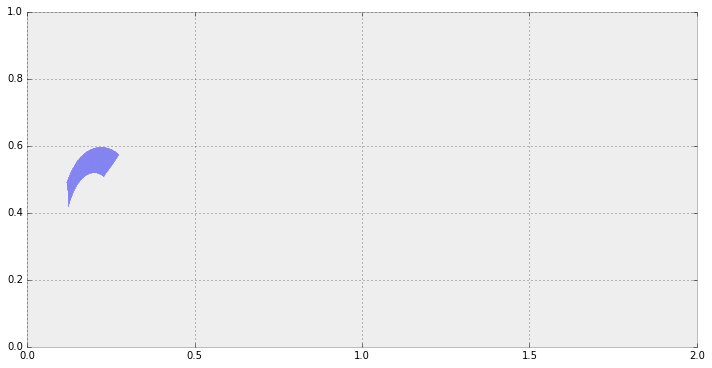

In [126]:
N  = 10000
X0 = grid_of_particles(N, w = 0.1)
# Array to hold all grid points after transport
X1 = np.zeros((2, N))

# Transport parameters
tmax = 5.0
dt   = 0.5

# Loop over grid and update all positions
# This is where parallelisation would happen, since
# each position is independent of all the others
tic = time()
# Keep only the last position, not the entire trajectory
X1 = endpoints(X0[:,:], tmax, dt)
toc = time()
print('Transport took %.3f seconds' % (toc - tic))

# Make scatter plot to show all grid points
fig = plt.figure(figsize = (12,6))
plt.scatter(X1[0,:], X1[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)